In [1]:
import numpy as np
import os
from batter.input_process import get_configure_from_file
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['JAX_PLATFORMS'] = 'cpu'

/scratch/users/yuzhuang/miniforge3/envs/batter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#sim_config = get_configure_from_file('./mor-msdr-rep2.in')
#work_dir = 'MOR_SC103_apo/v1/rep3/'
#work_dir = 'MOR_SC103_Gi/v1/rep2/'
sim_config = get_configure_from_file('./7t2g.in')
work_dir = '7T2G_MP_apo/v1/rep1/'

03-Dec-2024 08:17:01 | INFO | Converting lipid input: ['POPC']
03-Dec-2024 08:17:01 | INFO | New lipid_mol list: ['POPC', 'PA', 'PC', 'OL']


In [3]:
lambdas = sim_config.attach_rest

comp = 'm'
comp = 'n'
K = len(lambdas)

rest_files = [
    f'{work_dir}/fe/pose0/rest/{comp}{i:02d}/restraints.dat' for i in range(K)
]
# check if all files exist
for f in rest_files:
    if not os.path.exists(f):
        raise FileNotFoundError(f)

In [5]:
temperature = 310.0  # K
kB = 1.381e-23 * 6.022e23 / (4.184 * 1000.0)  # Boltzmann constant in kJ/mol/K
beta = 1/(kB * temperature)  # beta
R = 0
N_max = 20000  # Max frames for any simulation window, you should check this if you did some long runs


infile = f'{work_dir}/fe/pose0/rest/{comp}00/disang.rest'
disang = open(infile).readlines()
if (comp == 't'):
    for line in disang:
        cols = line.split()
        if len(cols) != 0 and (cols[-1] == "#Lig_TR"):
            R += 1
elif (comp == 'l' or comp == 'c'):
    for line in disang:
        cols = line.split()
        if len(cols) != 0 and (cols[-1] == "#Lig_C" or cols[-1] == "#Lig_D"):
            R += 1
elif (comp == 'a' or comp == 'r'):
    for line in disang:
        cols = line.split()
        if len(cols) != 0 and (cols[-1] == "#Rec_C" or cols[-1] == "#Rec_D"):
            R += 1
elif (comp == 'm' or comp == 'n'):
    for line in disang:
        cols = line.split()
        if len(cols) != 0 and (cols[-1] == "#Rec_C" or cols[-1] == "#Rec_D" or cols[-1] == "#Lig_TR" or cols[-1] == "#Lig_C" or cols[-1] == "#Lig_D"):
            R += 1

In [6]:
print("K= %5.0f  R= %5.0f" % (K, R))

K=    16  R=    36


In [7]:
# Calculate Statistical Inefficiency (g)
def calcg(data):
    sum = 0
    randnum = ("%05.0f" % (int(100000*np.random.random())))
    datafn = '/dev/shm/series.'+randnum+'.dat'
    acffn = '/dev/shm/acf.'+randnum+'.dat'
    cppfn = '/dev/shm/pt-acf.'+randnum+'.in'
    np.savetxt(datafn, data)
    cpptin = open(cppfn, 'w')
    cpptin.write("readdata "+datafn+" name "+randnum+"\nautocorr "+randnum+" out "+acffn+" noheader\n")
    cpptin.close()

    FNULL = open(os.devnull, 'w')
    run_with_log(f'{cpptraj} -i {cppfn}')

    with open(acffn, 'r') as acf:
        for line in acf:
            col = line.split()
            t = float(col[0]) - 1.0
    T = t

    with open(acffn, 'r') as acf:
        for line in acf:
            col = line.split()
            t = float(col[0]) - 1.0
            v = float(col[1])
            if t == 0:
                continue
            if v < 0.0:
                break
            sum += (1 - (t/T))*(v)

    run_with_log(f'rm {datafn} {acffn} {cppfn}')

    return 1+(2*sum)

# Allocate storage for simulation data
# N_k[k] is the number of snapshots to be used from umbrella simulation k

N = np.zeros([K], np.int32)
Neff = np.zeros([K], np.int32)
Nind = np.zeros([K], np.int32)
rty = ['d']*R                                     # restraint type (distance or angle)
rfc = np.zeros([K, R], np.float64)                 # restraint force constant
req = np.zeros([K, R], np.float64)                 # restraint target value
val = np.zeros([N_max, K, R], np.float64)           # value of the restrained variable at each frame n
g = np.zeros([K], np.float64)
u = np.zeros([N_max], np.float64)

In [8]:
mode = 'all'
# Read the simulation data
for k in range(K):
    print(k)
    # Read Equilibrium Value and Force Constant
    filename = f'{work_dir}/fe/pose0/rest/{comp}{k:02d}/disang.rest'
    infile = open(filename, 'r')
    disang = infile.readlines()
    infile.close()
    r = 0
    for line in disang:
        cols = line.split()
        if (comp == 't'):
            if len(cols) != 0 and (cols[-1] == "#Lig_TR"):
                natms = len(cols[2].split(','))-1
                req[k, r] = float(cols[6].replace(",", ""))
                if natms == 2:
                    rty[r] = 'd'
                    rfc[k, r] = float(cols[12].replace(",", ""))
                elif natms == 3:
                    rty[r] = 'a'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                elif natms == 4:
                    rty[r] = 't'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                else:
                    sys.exit("not sure about restraint type!")
                r += 1
        elif (comp == 'l' or comp == 'c'):
            if len(cols) != 0 and (cols[-1] == "#Lig_C" or cols[-1] == "#Lig_D"):
                natms = len(cols[2].split(','))-1
                req[k, r] = float(cols[6].replace(",", ""))
                if natms == 2:
                    rty[r] = 'd'
                    rfc[k, r] = float(cols[12].replace(",", ""))
                elif natms == 3:
                    rty[r] = 'a'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                elif natms == 4:
                    rty[r] = 't'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                else:
                    sys.exit("not sure about restraint type!")
                r += 1
        elif (comp == 'a' or comp == 'r'):
            if len(cols) != 0 and (cols[-1] == "#Rec_C" or cols[-1] == "#Rec_D"):
                natms = len(cols[2].split(','))-1
                req[k, r] = float(cols[6].replace(",", ""))
                if natms == 2:
                    rty[r] = 'd'
                    rfc[k, r] = float(cols[12].replace(",", ""))
                elif natms == 3:
                    rty[r] = 'a'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                elif natms == 4:
                    rty[r] = 't'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                else:
                    sys.exit("not sure about restraint type!")
                r += 1
        elif (comp == 'm' or comp == 'n'):
            if len(cols) != 0 and (cols[-1] == "#Rec_C" or cols[-1] == "#Rec_D" or cols[-1] == "#Lig_TR" or cols[-1] == "#Lig_C" or cols[-1] == "#Lig_D"):
                natms = len(cols[2].split(','))-1
                req[k, r] = float(cols[6].replace(",", ""))
                if natms == 2:
                    rty[r] = 'd'
                    rfc[k, r] = float(cols[12].replace(",", ""))
                elif natms == 3:
                    rty[r] = 'a'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                elif natms == 4:
                    rty[r] = 't'
                    rfc[k, r] = float(cols[12].replace(",", ""))*(np.pi/180.0)*(np.pi/180.0)  # Convert to degrees
                else:
                    sys.exit("not sure about restraint type!")
                r += 1

    # Read in Values for restrained variables for each simulation
    filename = rest_files[k]
    infile = open(filename, 'r')
    restdat = infile.readlines()     # slice off first 20 lines  readlines()[20:]
    infile.close()
    # Parse Data
    n = 0
    for line in restdat:
        if line[0] != '#' and line[0] != '@' and n < N_max:
            cols = line.split()
            for r in range(R):
                if rty[r] == 't':  # Do phase corrections
                    tmp = float(cols[r+1])
                    if tmp < req[k, r]-180.0:
                        val[n, k, r] = tmp + 360
                    elif tmp > req[k, r]+180.0:
                        val[n, k, r] = tmp - 360
                    else:
                        val[n, k, r] = tmp
                else:
                    val[n, k, r] = float(cols[r+1])
            n += 1

    N[k] = n

    # Calculate Reduced Potential
    if comp != 'u':  # Attach/Release Restraints
        if rfc[k, 0] == 0:
            tmp = np.ones([R], np.float64)*0.001  # CHECK THIS!! might interfere on protein attach
            u[0:N[k]] = np.sum(beta*tmp[0:R]*((val[0:N[k], k, 0:R]-req[k, 0:R])**2), axis=1)
        else:
            u[0:N[k]] = np.sum(beta*rfc[k, 0:R]*((val[0:N[k], k, 0:R]-req[k, 0:R])**2), axis=1)
    else:  # Umbrella/Translation
        u[0:N[k]] = (beta*rfc[k, 0]*((val[0:N[k], k, 0]-req[k, 0])**2))

    if mode == 'sub':
        g[k] = calcg(u[0:N[k]])
        subs = timeseries.subsampleCorrelatedData(np.zeros([N[k]]), g=g[k])
        Nind[k] = len(subs)
        Neff[k] = Nind[k]
    else:
        g[k] = 1.00
        Neff[k] = N[k]

    print("Processed Window %5.0f.  N= %12.0f.  g= %10.3f   Neff= %12.0f" % (k, N[k], g[k], Neff[k]))

Upot = np.zeros([K, K, np.max(Neff)], np.float64)

# Calculate Restraint Energy
for k in range(K):
    if mode == 'sub':  # subsampling
        subs = timeseries.subsampleCorrelatedData(np.zeros([N[k]]), g=g[k])
        for l in range(K):
            if comp != 'u':  # Attach Restraints
                Upot[k, l, 0:Neff[k]] = np.sum(
                    beta*rfc[l, 0:R]*((val[subs[0:Neff[k]], k, 0:R]-req[l, 0:R])**2), axis=1)
            else:  # Umbrella/Translation
                Upot[k, l, 0:Neff[k]] = (beta*rfc[l, 0]*((val[subs[0:Neff[k]], k, 0]-req[l, 0])**2))
    else:
        Neff[k] = N[k]
        for l in range(K):  # all samples
            if comp != 'u':  # Attach Restraints
                Upot[k, l, 0:Neff[k]] = np.sum(beta*rfc[l, 0:R]*((val[0:Neff[k], k, 0:R]-req[l, 0:R])**2), axis=1)
            else:  # Umbrella/Translation
                Upot[k, l, 0:Neff[k]] = (beta*rfc[l, 0]*((val[0:Neff[k], k, 0]-req[l, 0])**2))

0
Processed Window     0.  N=           80.  g=      1.000   Neff=           80
1
Processed Window     1.  N=           80.  g=      1.000   Neff=           80
2
Processed Window     2.  N=           80.  g=      1.000   Neff=           80
3
Processed Window     3.  N=           80.  g=      1.000   Neff=           80
4
Processed Window     4.  N=           80.  g=      1.000   Neff=           80
5
Processed Window     5.  N=           80.  g=      1.000   Neff=           80
6
Processed Window     6.  N=           80.  g=      1.000   Neff=           80
7
Processed Window     7.  N=           80.  g=      1.000   Neff=           80
8
Processed Window     8.  N=           80.  g=      1.000   Neff=           80
9
Processed Window     9.  N=           80.  g=      1.000   Neff=           80
10
Processed Window    10.  N=           80.  g=      1.000   Neff=           80
11
Processed Window    11.  N=           80.  g=      1.000   Neff=           80
12
Processed Window    12.  N=        

In [9]:
import pandas as pd
from alchemlyb.estimators import MBAR

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [10]:
Upot.shape

u_df = pd.DataFrame(columns=['time', 'fep-lambda'] + list(lambdas))

In [11]:
data_frames = []

for i, u_pot_lambda in enumerate(Upot):
    fep = u_pot_lambda.T  # Transpose if needed
    time = np.arange(fep.shape[0])  # Create the time array based on the number of rows in `fep`
    fep_lambda = np.ones(fep.shape[0]) * lambdas[i]  # Create the fep-lambda array based on the current lambda
    # Stack the arrays horizontally
    result = np.hstack([time[:, None], fep_lambda[:, None], fep])  
    
    df = pd.DataFrame(result,
                      columns=['time', 'fep-lambda'] + list(lambdas))
    data_frames.append(df)

# Combine all DataFrames into a single DataFrame
u_df = pd.concat(data_frames, ignore_index=True)
# set index to time and fep-lambda
u_df.set_index(['time', 'fep-lambda'], inplace=True)

In [12]:
mbar_coul = MBAR()
mbar_coul.fit(u_df)


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************



MBAR()

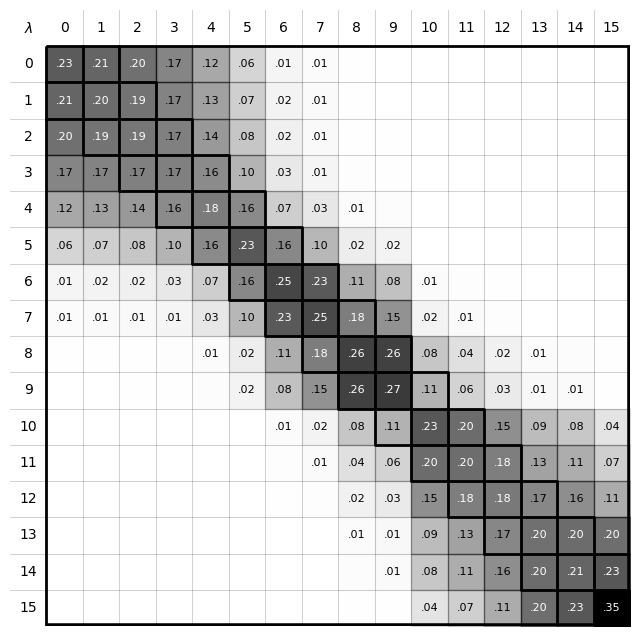

In [13]:
from alchemlyb.visualisation import plot_mbar_overlap_matrix
ax = plot_mbar_overlap_matrix(mbar_coul.overlap_matrix)

In [14]:
mbar_coul.delta_f_

,0.00,0.10,0.24,0.56,1.33,3.16,7.50,10.50,17.78,20.00,42.17,50.00,60.00,75.00,80.00,100.00
0.00,0.000000,0.289705,0.669061,1.447897,2.993984,5.684168,9.900099,12.067733,16.079575,17.070850,24.069569,25.859332,27.862917,30.433130,31.199038,33.914041
0.10,-0.289705,0.000000,0.379356,1.158192,2.704279,5.394463,9.610394,11.778028,15.789870,16.781145,23.779864,25.569627,27.573212,30.143425,30.909333,33.624336
0.24,-0.669061,-0.379356,0.000000,0.778836,2.324924,5.015107,9.231038,11.398672,15.410514,16.401789,23.400508,25.190271,27.193857,29.764070,30.529977,33.244980
0.56,-1.447897,-1.158192,-0.778836,0.000000,1.546088,4.236272,8.452202,10.619837,14.631678,15.622953,22.621672,24.411436,26.415021,28.985234,29.751141,32.466145
1.33,-2.993984,-2.704279,-2.324924,-1.546088,0.000000,2.690184,6.906114,9.073749,13.085590,14.076866,21.075584,22.865348,24.868933,27.439146,28.205053,30.920057
3.16,-5.684168,-5.394463,-5.015107,-4.236272,-2.690184,0.000000,4.215930,6.383565,10.395406,11.386682,18.385401,20.175164,22.178749,24.748962,25.514870,28.229873
7.50,-9.900099,-9.610394,-9.231038,-8.452202,-6.906114,-4.215930,0.000000,2.167635,6.179476,7.170751,14.169470,15.959234,17.962819,20.533032,21.298939,24.013943
10.50,-12.067733,-11.778028,-11.398672,-10.619837,-9.073749,-6.383565,-2.167635,0.000000,4.011841,5.003117,12.001836,13.791599,15.795184,18.365397,19.131305,21.846308
17.78,-16.079575,-15.789870,-15.410514,-14.631678,-13.085590,-10.395406,-6.179476,-4.011841,0.000000,0.991275,7.989994,9.779758,11.783343,14.353556,15.119463,17.834467
20.00,-17.070850,-16.781145,-16.401789,-15.622953,-14.076866,-11.386682,-7.170751,-5.003117,-0.991275,0.000000,6.998719,8.788482,10.792067,13.362280,14.128188,16.843191


In [15]:
energy_kcal = mbar_coul.delta_f_.values[0, -1] * 0.5922 / 298 * 310

In [16]:
print(f'Free energy difference: {energy_kcal:.2f} kcal/mol')

Free energy difference: 20.89 kcal/mol


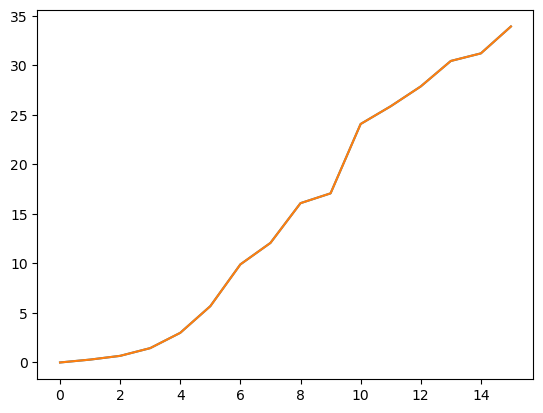

In [17]:
import matplotlib.pyplot as plt
plt.plot(mbar_coul.delta_f_.values[0, :])
plt.plot(-mbar_coul.delta_f_.values[:, 0])